### 3. Sentiment Analysis on IMDb Movie Reviews

In [ ]:
#importing Libraries
import tensorflow as tf
import os
import shutil
import re
import string
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, losses
import pandas as pd

print(f"Version : {tf.__version__}")

Version : 2.12.0


### 3.1 Loading the data

In [ ]:
link = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset = tf.keras.utils.get_file(
    fname='aclImdb_v1',
    origin=link,
    untar=True,
    cache_dir='.',
    cache_subdir=''
)

dataset_dir = '/content/aclImdb'
print(f"List of Directories : {os.listdir(dataset_dir)}")

List of Directories : ['test', 'imdb.vocab', 'README', 'imdbEr.txt', 'train']


In [ ]:
train_dir = os.path.join(dataset_dir, 'train')
print(f"Train Directory : {os.listdir(train_dir)}")

Train Directory : ['unsupBow.feat', 'labeledBow.feat', 'neg', 'unsup', 'pos', 'urls_neg.txt', 'urls_unsup.txt', 'urls_pos.txt']


In [ ]:
#Viewing a Sample File

sample_file = os.path.join(train_dir, 'pos/10000_8.txt')
with open(sample_file) as f :
  print(f.read())

Homelessness (or Houselessness as George Carlin stated) has been an issue for years but never a plan to help those on the street that were once considered human who did everything from going to school, work, or vote for the matter. Most people think of the homeless as just a lost cause while worrying about things such as racism, the war on Iraq, pressuring kids to succeed, technology, the elections, inflation, or worrying if they'll be next to end up on the streets.<br /><br />But what if you were given a bet to live on the streets for a month without the luxuries you once had from a home, the entertainment sets, a bathroom, pictures on the wall, a computer, and everything you once treasure to see what it's like to be homeless? That is Goddard Bolt's lesson.<br /><br />Mel Brooks (who directs) who stars as Bolt plays a rich man who has everything in the world until deciding to make a bet with a sissy rival (Jeffery Tambor) to see if he can live in the streets for thirty days without th

In [ ]:
# Load the data in suitable format for training

# 1. Remove Unwanted Directories - unsup
remove_dir = os.path.join(train_dir, "unsup")
shutil.rmtree(remove_dir)

# 2. Load the data into batches of 32
batch_size = 32
seed = 42
raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    directory=train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed
)


Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [ ]:
# 3. Viewing the data
for text_batch, label_batch in raw_train_ds.take(1) :
  for i in range(3) :
    print(f"Review {text_batch.numpy()[i]}")
    print(f"Label {label_batch.numpy()[i]}")


Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In [ ]:
# 4. Understanding Class Names
print(f"0 implies {raw_train_ds.class_names[0]}")
print(f"1 implies {raw_train_ds.class_names[1]}")


0 implies neg
1 implies pos


In [ ]:
# 5. Creating Validation Dataset
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    directory=train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [ ]:
# 6. Creating Test Dataset

test_dir = '/content/aclImdb/test'
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    directory=test_dir,
    batch_size=batch_size
)
raw_test_ds

Found 25000 files belonging to 2 classes.


<_BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

### 3.2 Preparing the dataset for training

In [ ]:
# 1. Doing Custom Standardization to remove <br> tags and punctuation

def custom_standardization(input_string) :
  lowercase = tf.strings.lower(input_string)
  stripped_string = tf.strings.regex_replace(lowercase, '<br />', '')
  return tf.strings.regex_replace(stripped_string,
                                  '[%s]' % re.escape(string.punctuation),
                                  ''
                                  )


In [ ]:
# 2. Doing Vectorisation for the text dataset

max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length
)

In [ ]:
# 3. Call adapt to fit the state of preprocessing layer in the dataset - To build an index of strings and integers
train_text = raw_train_ds.map(lambda x, y : x)
vectorize_layer.adapt(train_text)

In [ ]:
def vectorize_text(text, label) :
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [ ]:
# Testing the preprocessing layer

text_batch, lebel_batch = next(iter(raw_train_ds))
first_review = text_batch[0]
first_label = label_batch[0]
print(f"Review : \n{first_review}")
print(f"Label : {raw_train_ds.class_names[first_label]}")
print(f"Vectorized Text : {vectorize_text(first_review, first_label)}")

Review : 
b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.'
Label : neg
Vectorized Text : (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  85,   17,  257,    2,  222,    1,  574,   30,  227,   10, 2401,
           1,   52,   23,   25,  426,  248,   12,  306,  279,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,

In [ ]:
# Vocabulary
print(f"123 -> {vectorize_layer.get_vocabulary()[123]}")
print(f"345 -> {vectorize_layer.get_vocabulary()[345]}")
print(f"Length : {len(vectorize_layer.get_vocabulary())}")

123 -> better
345 -> wrong
Length : 10000


In [ ]:
# Applying Vectorization Layer to Train, Test and Validation dataset
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

### 3.3 Configuring the dataset for performance

In [ ]:
# 1. .cache() - To create a performant on-disk cache - Efficient to read small files
# 2. .prefetch() - Overlaps data preprocessing and model execution while training

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### 3.4 Creating a Model

In [ ]:
embedding_dim = 16

text_model1 = tf.keras.Sequential([
    layers.Embedding(max_features + 1, embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(1)
])
text_model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          160016    
                                                                 
 dropout_2 (Dropout)         (None, None, 16)          0         
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
________________________________________________

### 3.5 Loss Function and Optimizer

In [ ]:
text_model1.compile(
    loss=losses.BinaryCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=tf.metrics.BinaryAccuracy(threshold=0.0)
)

### 3.6 Train the model

In [ ]:
epochs = 10

history = text_model1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)
history

Epoch 1/10
625/625 [==============================] - 18s 23ms/step - loss: 0.6645 - binary_accuracy: 0.6902 - val_loss: 0.6174 - val_binary_accuracy: 0.7702
Epoch 2/10
625/625 [==============================] - 6s 10ms/step - loss: 0.5520 - binary_accuracy: 0.7991 - val_loss: 0.5029 - val_binary_accuracy: 0.8204
Epoch 3/10
625/625 [==============================] - 6s 9ms/step - loss: 0.4496 - binary_accuracy: 0.8418 - val_loss: 0.4253 - val_binary_accuracy: 0.8468
Epoch 4/10
625/625 [==============================] - 6s 10ms/step - loss: 0.3839 - binary_accuracy: 0.8626 - val_loss: 0.3786 - val_binary_accuracy: 0.8610
Epoch 5/10
625/625 [==============================] - 7s 11ms/step - loss: 0.3400 - binary_accuracy: 0.8770 - val_loss: 0.3498 - val_binary_accuracy: 0.8682
Epoch 6/10
625/625 [==============================] - 5s 9ms/step - loss: 0.3091 - binary_accuracy: 0.8864 - val_loss: 0.3304 - val_binary_accuracy: 0.8710
Epoch 7/10
625/625 [==============================] - 6s 9m

### 3.7 Evaluate the model

In [ ]:
loss, accuracy = text_model1.evaluate(test_ds)
print(f"Loss : {loss * 100 :2.2f}%")
print(f"Accuracy : {accuracy * 100 :2.2f}%")

782/782 [==============================] - 6s 8ms/step - loss: 0.3146 - binary_accuracy: 0.8712
Loss : 31.46%
Accuracy : 87.12%


### 3.8 Plotting the metrics

In [ ]:
history_dc = history.history
print(f"Entries : \n{history_dc.keys()}")

Entries : 
dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


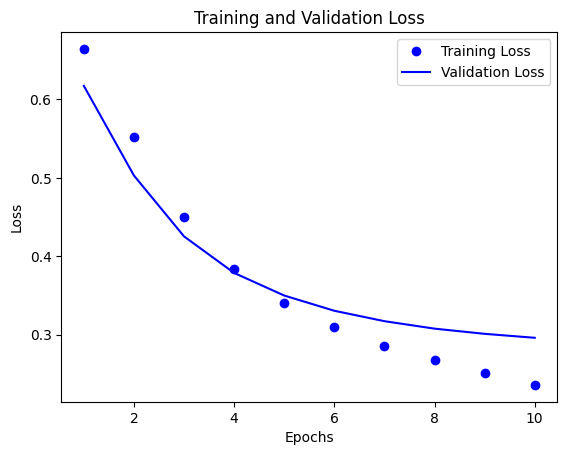

In [ ]:
acc = history_dc['binary_accuracy']
val_acc = history_dc['val_binary_accuracy']
loss = history_dc['loss']
val_loss = history_dc['val_loss']

# Plotting the Loss curve
epochs = range(1, len(acc)+1)
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

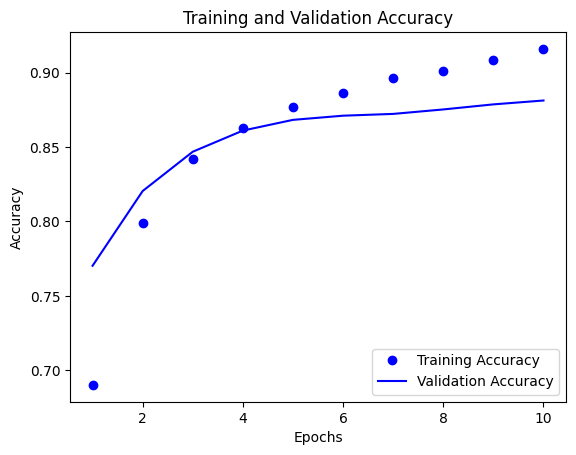

In [ ]:
# Plotting the Accuracy Curve
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# The graph shows Validation Loss and Accuracy peaks before Training Loss and Accuracy due to Overfitting

### 3.9 Exporting the model

In [ ]:
#Including the vectorize layer with the model
text_model2 = tf.keras.Sequential([
    vectorize_layer,
    text_model1,
    layers.Activation('sigmoid')
])


text_model2.compile(
    loss = losses.BinaryCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

# Test the model with raw_test_ds

loss, accuracy = text_model2.evaluate(raw_test_ds)
print(f"Loss : {loss}")
print(f"Accuracy : {accuracy}")

/usr/local/lib/python3.10/dist-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


782/782 [==============================] - 6s 7ms/step - loss: 0.3146 - accuracy: 0.8712
Loss : 0.3146143853664398
Accuracy : 0.8712000250816345


### 3.10 Testing the model on new Data

In [ ]:
examples = [
    'The movie is awesome',
    'This cinema is great',
    'The film was okay',
    'Best film ever made',
    'Never watched a film like this one'
]

preds = text_model2.predict(examples)
threshold = 0.5
output = list()
for i in range(len(examples)) :
  output.append({
      'Review' : examples[i],
      'Category' : raw_train_ds.class_names[int(float(preds[i]) > threshold)]
  })

1/1 [==============================] - 0s 44ms/step


In [ ]:
output = pd.DataFrame(output)
display(output)

,Review,Category
0,The movie is awesome,pos
1,This cinema is great,pos
2,The film was okay,neg
3,Best film ever made,pos
4,Never watched a film like this one,pos
